In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

In [15]:
df=pd.read_csv("data.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [17]:
#Converting the order date column in datetime format.

df["Order Date"] =pd.to_datetime(df["Order Date"],errors="coerce")

In [18]:
#Grouping data by month end dates using order date and calculating total sales.

monthly_sales= df.groupby(pd.Grouper(key="Order Date",freq="ME"))["Sales"].sum().round(2)
monthly_sales.head()

Order Date
2015-01-31    19546.16
2015-02-28    11678.99
2015-03-31     6716.04
2015-04-30    12455.48
2015-05-31    15165.05
Name: Sales, dtype: float64

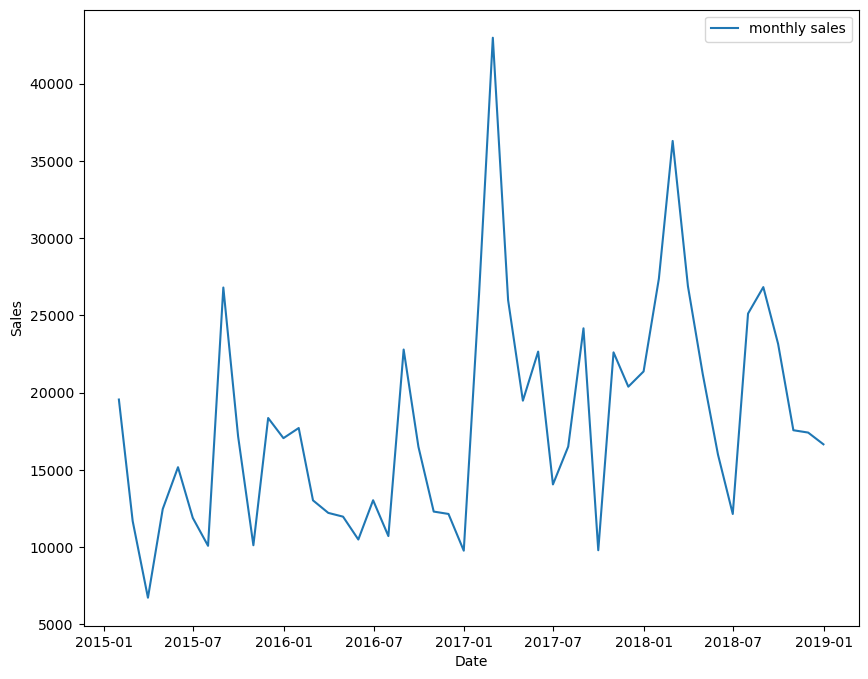

In [19]:
plt.figure(figsize=(10,8))
plt.plot(monthly_sales, label="monthly sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
#plt.grid()
plt.show()

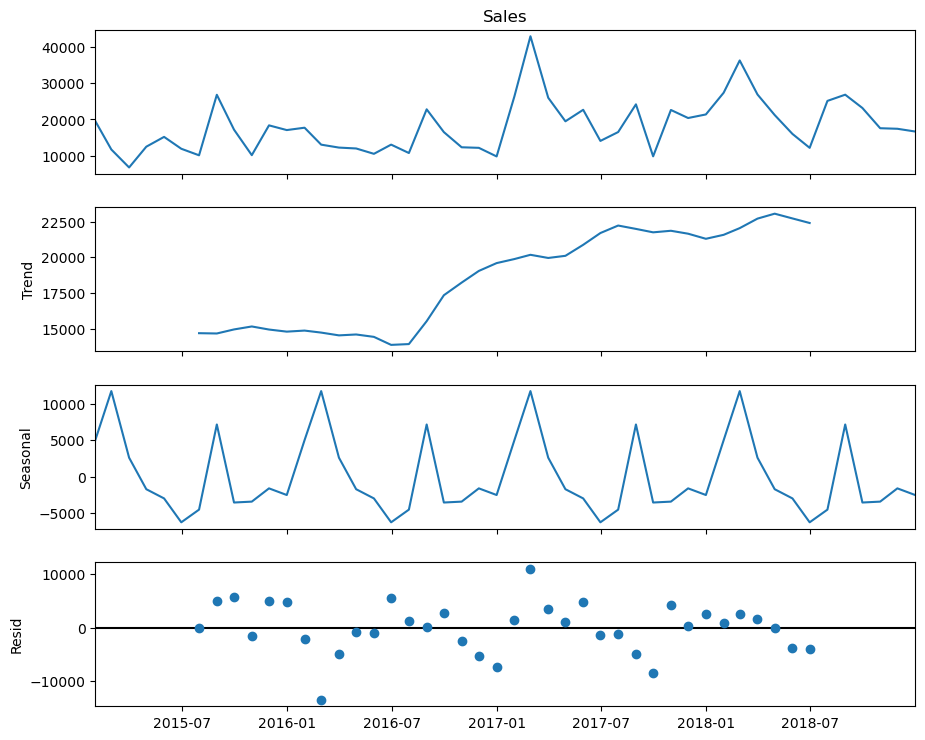

In [20]:
#Performing seasonal decomposition time series using an  additive model.

decomposition= seasonal_decompose(monthly_sales,model="additive")
fig=decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

In [21]:
#testing the stationarity of a time series using ADF test. 

def check_stationarity(timeseries):
    result=adfuller(timeseries)
    print("agumented Dickey-Fuller test results:")
    print("ADF Statistic", result[0])
    print("P-Value",result[1])
    print("Critical values")
    for key,value in result[4].items():
      print(f'\t{key}: {value}')
    return result[1] < 0.05

is_stationary= check_stationarity(monthly_sales)
print(f"\nTime series is {"Stationary" if is_stationary else "non-stationary"}")

agumented Dickey-Fuller test results:
ADF Statistic -4.180261641401268
P-Value 0.0007114671298361002
Critical values
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064

Time series is Stationary


In [22]:
# Creating an ARIMA model.
auto_model=auto_arima(monthly_sales,
                       start_P=0,start_Q=0,
                       max_P=5,max_Q=5,
                       m=12,
                       seasonal=True,
                       d=None,
                       trace= True,
                       error_action= "ignore",
                       suppress_warnings= True,
                       stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=967.897, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=978.479, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=975.530, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=976.492, Time=0.01 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=966.538, Time=0.28 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=971.803, Time=0.32 sec
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=967.292, Time=0.26 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=964.684, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=965.889, Time=0.14 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=966.030, Time=0.76 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=965.920, Time=0.57 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=96

In [23]:
# Define and fit the ARIMA model with the correct class

model = ARIMA(monthly_sales, 
              order=auto_model.order, 
              seasonal_order=auto_model.seasonal_order
)
result = model.fit()


c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [24]:
# 12-step monthly forecast using the ARIMA model

forecast_periods=12
forecast=result.get_forecast(steps=forecast_periods)
mean_forecast=forecast.predicted_mean

In [25]:
#generating confidence intervals for the forecasted values at different confidence levels

conf_int_95 =forecast.conf_int(alpha=0.05)
conf_int_80 =forecast.conf_int(alpha=0.20)
conf_int_70 =forecast.conf_int(alpha=0.30)

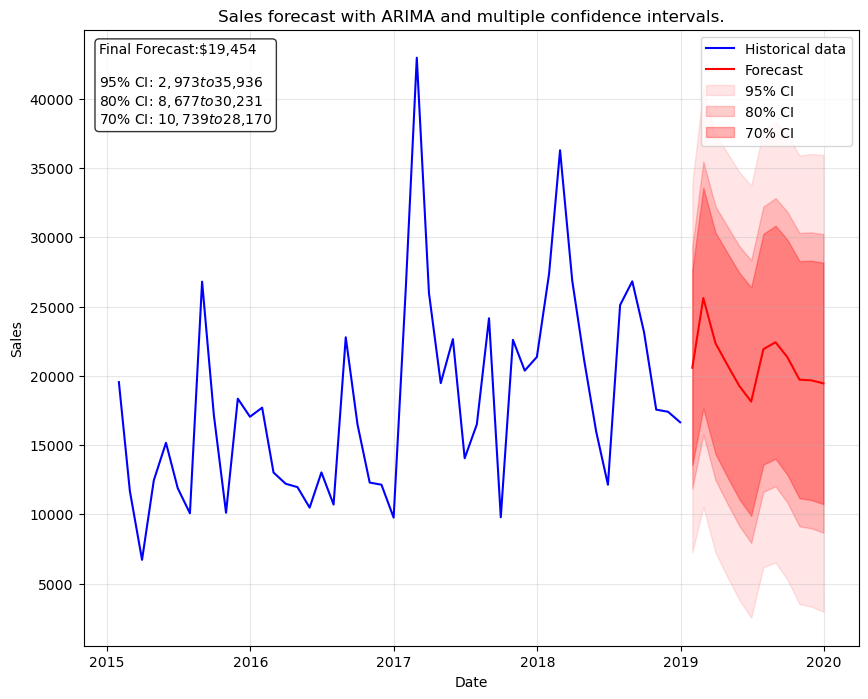

In [28]:
plt.figure(figsize=(10,8))

#Plotting historical and forecasted data

plt.plot(monthly_sales,label="Historical data", color="blue")
plt.plot(mean_forecast,label="Forecast",color="red")

#Plotting confidence intervals.

plt.fill_between(mean_forecast.index,
                 conf_int_95.iloc[:,0],
                 conf_int_95.iloc[:,1],
                 color="red",alpha=0.1,
                 label= "95% CI"
)

plt.fill_between(mean_forecast.index,
                 conf_int_80.iloc[:,0],
                 conf_int_80.iloc[:,1],
                 color="red",alpha=0.2,
                 label= "80% CI"
)

plt.fill_between(mean_forecast.index,
                 conf_int_70.iloc[:,0],
                 conf_int_70.iloc[:,1],
                 color="red",alpha=0.3,
                 label= "70% CI"
)

plt.title("Sales forecast with ARIMA and multiple confidence intervals.")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)

#Getting the final values.

last_forecast=mean_forecast.iloc[-1]
ranges_95_lower=conf_int_95.iloc[-1,0]
ranges_95_upper=conf_int_95.iloc[-1,1]
ranges_80_lower=conf_int_80.iloc[-1,0]
ranges_80_upper=conf_int_80.iloc[-1,1]
ranges_70_lower=conf_int_70.iloc[-1,0]
ranges_70_upper=conf_int_70.iloc[-1,1]

#Creating an info text.
info_text= f"Final Forecast:${last_forecast:,.0f}\n\n"\
           f"95% CI: ${ranges_95_lower:,.0f} to ${ranges_95_upper:,.0f}\n"\
           f"80% CI: ${ranges_80_lower:,.0f} to ${ranges_80_upper:,.0f}\n"\
           f"70% CI: ${ranges_70_lower:,.0f} to ${ranges_70_upper:,.0f}"

plt.text(
          0.02,0.98,info_text,
          transform=plt.gca().transAxes,
          verticalalignment="top",
          bbox=dict(boxstyle="round",facecolor="white",alpha=0.8))

plt.show()





In [45]:
#calculating and displaying metrics.
print("\nModel Performance Metrics:")
mse=mean_squared_error(monthly_sales,result.fittedvalues)
rmse=np.sqrt(mse)
mae=mean_absolute_error(monthly_sales,result.fittedvalues)
print(f"Mean Squared Error(MSE):{mse:.2f}")
print(f"Root Mean Squared Error(RMSE):{rmse:.2f}")
print(f"Mean Absolute Error(MSE):{mae:.2f}")

# Forecast info:
print("\nForecast ranges for final period.")
print(f"Point Forecast: ${last_forecast:,.2f}")
print("\nConfidence intervals:")
print(f"95% CI: ${ranges_95_lower:,.2f} to ${ranges_95_upper:,.2f}")
print(f"80% CI: ${ranges_80_lower:,.2f} to ${ranges_80_upper:,.2f}")
print(f"70% CI: ${ranges_70_lower:,.2f} to ${ranges_70_upper:,.2f}")

# Calculating and printing interval widths.
print("\nInterval widths as forecast percentages")
print(f"95% CI: ±{((ranges_95_upper-ranges_95_lower)/2/last_forecast*100):,.1f}%")
print(f"80% CI: ±{((ranges_80_upper-ranges_80_lower)/2/last_forecast*100):,.1f}%")
print(f"70% CI: ±{((ranges_70_upper-ranges_70_lower)/2/last_forecast*100):,.1f}%")

# Creating a forecast dataframe.

forecast_df =pd.DataFrame({
    "Forecast":mean_forecast,
    "95% Lower":conf_int_95.iloc[:,0],
    "95% Upper":conf_int_95.iloc[:,1],
    "80% Lower":conf_int_80.iloc[:,0],
    "80% Upper":conf_int_80.iloc[:,1],
    "70% Lower":conf_int_70.iloc[:,0],
    "70% Upper":conf_int_70.iloc[:,1],

})

print("\nDetailed forecast with confidence intervals:")
print(forecast_df)



Model Performance Metrics:
Mean Squared Error(MSE):44881665.93
Root Mean Squared Error(RMSE):6699.38
Mean Absolute Error(MSE):4548.54

Forecast ranges for final period.
Point Forecast: $19,454.29

Confidence intervals:
95% CI: $2,972.57 to $35,936.00
80% CI: $8,677.48 to $30,231.10
70% CI: $10,738.72 to $28,169.86

Interval widths as forecast percentages
95% CI: ±84.7%
80% CI: ±55.4%
70% CI: ±44.8%

Detailed forecast with confidence intervals:
                Forecast     95% Lower     95% Upper     80% Lower  \
2019-01-31  20586.762521   7259.240203  33914.284839  11872.364080   
2019-02-28  25614.171947  10539.179174  40689.164721  15757.163991   
2019-03-31  22352.406565   7235.246286  37469.566845  12467.826759   
2019-04-30  20804.063426   5499.350911  36108.775941  10796.849804   
2019-05-31  19255.163387   3804.291294  34706.035481   9152.381154   
2019-06-30  18138.625822   2535.086701  33742.164942   7936.019985   
2019-07-31  21925.327717   6172.279774  37678.375660  11624.9

In [54]:
models=[]
specifications=[
    {
       "name":"fixed parameters",
       "model":ExponentialSmoothing(
           monthly_sales,
           seasonal_periods=12,
           trend="add",
           seasonal="add",
           damped_trend=True
       ).fit(
           smoothing_level=0.2,
           smoothing_trend=0.1,
           smoothing_seasonal=0.1,
           damping_trend=0.98,
           optimized=False
       )
    },
    {
        "name":"Multicaptive seasonal",
        "model":ExponentialSmoothing(
            monthly_sales,
            seasonal_periods=12,
            trend="add",
            seasonal="mul",
            damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False

        )
    },
    {
        "name":"multicaptive trend",
        "model":ExponentialSmoothing(
            monthly_sales,
            seasonal_periods=12,
            trend="mul",
            seasonal="add",
            damped_trend=True
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
    }
]

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [56]:
results=[]
for spec in specifications:
    model=spec["model"]
    name=spec["name"]

# Calculating metrics.
rmse=np.sqrt(mean_squared_error(monthly_sales,model.fittedvalues))
mae=mean_absolute_error(monthly_sales,model.fittedvalues)

results.append({
    "name":name,
    "rmse":rmse,
    "mae":mae,
    "model":model
})

In [57]:
best_model=min(results,key=lambda x: x["rmse"])
hw_model=best_model["model"]
hw_forecast=hw_model.forecast(12)

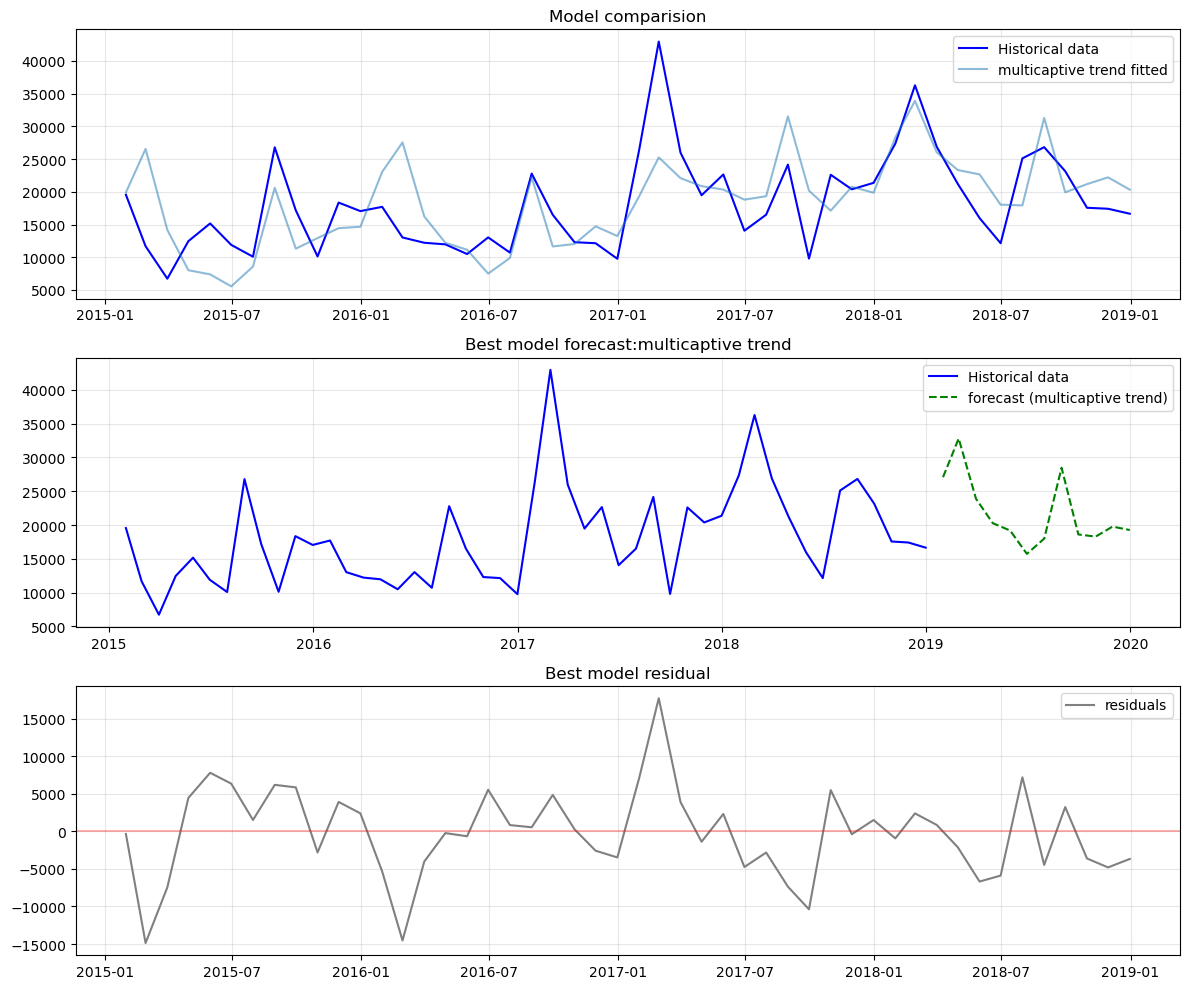

In [63]:
plt.figure(figsize=(12,10))

# Plotting the subplots of all models
plt.subplot(3,1,1)
plt.plot(monthly_sales.index,monthly_sales,label="Historical data",color="blue")
for result in results:
    plt.plot(result["model"].fittedvalues.index,
             result["model"].fittedvalues,
             label=f"{result["name"]} fitted",alpha=0.5)
plt.title("Model comparision")
plt.legend()
plt.grid(True, alpha=0.3)

#  Best model forecast.
plt.subplot(3,1,2)
plt.plot(monthly_sales.index,monthly_sales,label="Historical data",color="blue")
plt.plot(hw_forecast.index,hw_forecast,
         label=f"forecast ({best_model["name"]})",
         color="green",linestyle="--")
plt.title(f"Best model forecast:{best_model["name"]}")
plt.legend()
plt.grid(True,alpha=0.3)

# Residual of best
plt.subplot(3,1,3)
residuals=monthly_sales-hw_model.fittedvalues
plt.plot(monthly_sales.index,residuals,label="residuals",color="gray")
plt.axhline(y=0,color="r",linestyle="-",alpha=0.3)
plt.title("Best model residual")
plt.legend()
plt.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
print("\nModel comparison")
for result in results:
    print(f"\n{result["name"]}:")
    print(f"RMSE: ${result["rmse"]:.2f}")
    print(f"MAE: ${result["mae"]:.2f}")

print(f"\nBest Model: {best_model["name"]}")
print(f"Best RMSE: ${best_model["rmse"]:.2f}")



Model comparison

multicaptive trend:
RMSE: $5889.23
MAE: $4534.55

Best Model: multicaptive trend
Best RMSE: $5889.23
